In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm_notebook
import glob
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.init as init

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Neural Network

In [15]:
%%capture
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('path/to/save/data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('path/to/save/data', train=False, download=True, transform=transform)

In [16]:
input_size = 28 * 28
hidden_size = 64
output_size = 10
learning_rate = 0.1
num_epochs = 1000
train_batch_size = 60000
test_batch_size = 10000

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [18]:
weights_input_hidden = np.random.randn(hidden_size+1, input_size+1)
weights_hidden_output = np.random.randn(output_size, hidden_size+1)

In [20]:
train_inputs = None
train_labels = None
for images, labels in train_loader:
    numpy_images = images.numpy()
    train_labels = labels.numpy()
    train_inputs = numpy_images.reshape(train_batch_size, -1)
    train_labels = np.eye(output_size)[train_labels]
    # X0 = np.ones((inputs.shape[0],1))
    # train_inputs = np.hstack((X0, inputs))

In [21]:
test_inputs = None
test_labels = None
for images, labels in test_loader:
    numpy_images = images.numpy()
    test_labels = labels.numpy()
    test_inputs = numpy_images.reshape(test_batch_size, -1)
    test_labels = np.eye(output_size)[test_labels]
    # inputs = numpy_images.reshape(test_batch_size, -1)
    # X0 = np.ones((inputs.shape[0],1))
    # test_inputs = np.hstack((X0, inputs))

In [22]:
class NeuralNetwork():
  def mean_squared_error(self, y_pred, y_true):
    total = y_true.shape[0]
    result = 0.5*((y_true - y_pred)**2)
    result= (1/total)*np.sum(result)

    return result

  def cross_entropy_loss(self, y_pred, y_true):
    total = y_true.shape[0]
    result = y_true*np.log(y_pred)
    result = (1/total)*(-np.sum(result))
    return result

  def accuracy(self, y_pred, y_true):
    count = 0
    total = len(y_pred)
    for i in range(total) :
        if y_pred[i] == y_true[i]:
            count = count + 1
    acc = count/total
    acc = acc*100

    return acc

  def softmax(self, x):
    summation = np.sum(np.exp(x), axis=1, keepdims=True)
    result = np.exp(x)/summation
    return result

  def sigmoid(self, x):
    #print("initial",x[0])
    result = 1/(1 + np.exp(-x))
    #print("final", result[0])
    return result

  def __init__(self, nodes_per_layer):
    self.num_layers = len(nodes_per_layer) # includes input layer
    self.nodes_per_layer = nodes_per_layer
    self.input_shape = nodes_per_layer[0]
    self.output_shape = nodes_per_layer[-1]
    self.__init_weights(nodes_per_layer)

  def __init_weights(self, nodes_per_layer):
    self.weights_ = []
    # self.biases_ = []
    for i,_ in enumerate(nodes_per_layer):
        if i == 0:
            # skip input layer, it does not have weights/bias
            continue
        constant = 1
        if i == 1:
          constant = 1/10
        else:
          constant = 1/2

        # weight_matrix = constant*(np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i])))
        # weight_matrix = np.zeros((nodes_per_layer[i-1], nodes_per_layer[i])) # For zeroes
        weight_matrix = (np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]))) # For normal
        #print(weight_matrix)
        self.weights_.append(weight_matrix)
        # bias_vector = np.zeros(shape=(nodes_per_layer[i]))
        # self.biases_.append(bias_vector)


  def forward_pass(self, input_data):
    temp = []
    current = input_data
    activations = []
    for i in range(len(self.weights_) - 1):
      current = self.sigmoid(np.matmul(current, self.weights_[i]))# + self.biases_[i])
      activations.append(current)
    activations.append(self.softmax(np.matmul(current, self.weights_[-1])))# + self.biases_[-1]))
    #print(activations[-1])

    return activations

  def backward_pass(self, targets, layer_activations):
    deltas = []
    output = layer_activations[-1]
    error_deriv = output - targets
    next_term = error_deriv
    #dydw1 = np.matmul(layer_activations[-2].T, error_deriv)
    deltas.append(next_term)
    for i in range(len(layer_activations)-1, 0, -1):
        sig = layer_activations[i-1]*(1-layer_activations[i-1])
        temp = np.matmul(next_term, self.weights_[i].T)
        next_term = sig*temp
        deltas.append(next_term)
    return deltas

  def weight_update(self, deltas, layer_inputs, lr):
    total = layer_inputs[0].shape[0]
    deltas.reverse()
    updates = []
    for i in range(len(deltas)):
        updates.append(np.matmul(layer_inputs[i].T, deltas[i]))
    for i in range(len(updates)):
        self.weights_[i] = self.weights_[i] - (1/total)*lr*(updates[i])
        # self.biases_[i] = self.biases_[i] - (1/total)*lr*(deltas[i].sum(axis=0, keepdims=True))



  def fit(self, X, Y, epochs, lr=1e-3):
    history = []
    accuracy = []
    print(X.shape)
    print(Y.shape)
    batch = X.shape[0]
    idx = np.arange(batch)
    progress_bar = tqdm_notebook(total=epochs, desc='Training')
    prev = 0
    counts = 0
    batches = 10000
    for epoch in range(epochs):
      np.random.shuffle(idx)
      Xs = X[idx[:batches],:]
      Ys = Y[idx[:batches],:]
      current_loss = 0
      counts += 1
      activations = self.forward_pass(Xs)
      deltas = self.backward_pass(Ys, activations)
      layer_inputs = [Xs] + activations[:-1]
      self.weight_update(deltas, layer_inputs, lr)# Weight update

      preds = self.predict(Xs)
      if epoch % 2 == 0:
        los, acc = self.evaluate(test_inputs, test_labels)
        postfix = {
            'Accuracy': acc,
            'Loss': los,
        }
        progress_bar.set_postfix(postfix)

      los, acc = self.evaluate(Xs, Ys)
      # current_loss += self.cross_entropy_loss(preds, Ys)
      history.append(los)
      accuracy.append(acc)
      progress_bar.update(1)
    progress_bar.close()
    print(counts)

    return history, accuracy

  def predict(self, Xs):
    predictions = []
    predictions = self.forward_pass(Xs)[-1]
    return predictions

  def evaluate(self, Xs, Ys):
    pred = self.predict(Xs)
    return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))

In [ ]:
nn = NeuralNetwork(nodes_per_layer=[input_size, 300, 10])
history, accuracy = nn.fit(train_inputs, train_labels, epochs=100, lr=0.1)

In [ ]:
res = nn.evaluate(test_inputs, test_labels)
print("Loss:", res[0], "Accuracy:", res[1])

Loss: 0.27980861288906833 Accuracy: 91.99000000000001


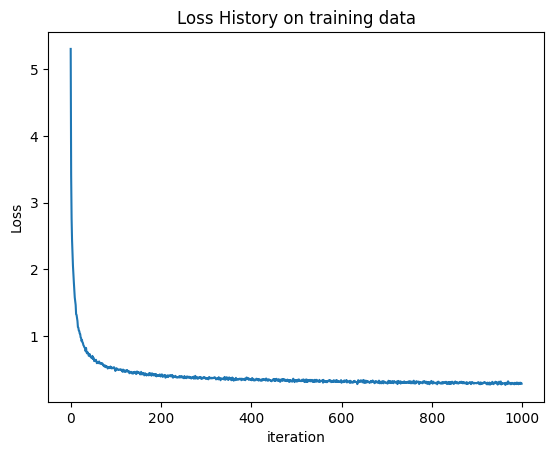

In [ ]:
plt.plot(history)
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.title("Loss History on training data")
plt.show()

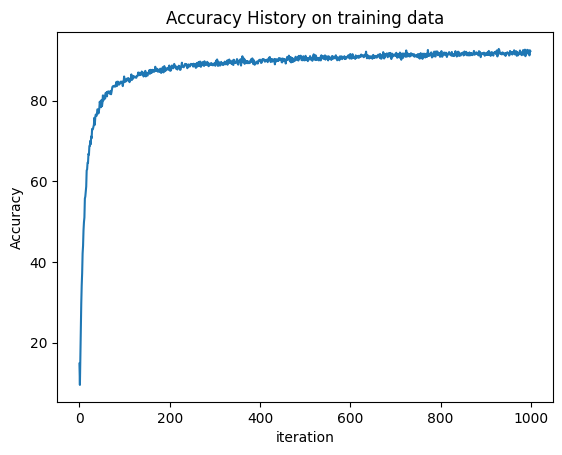

In [ ]:
plt.plot(accuracy)
plt.xlabel("iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy History on training data")
plt.show()

# Tensorflow NN

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28, 1)))
model.add(layers.Dense(300, activation='sigmoid'))
model.add(layers.Dense(10, activation='softmax'))
# model.add(layers.Dense(300, activation='sigmoid', kernel_initializer=initializers.Zeros()))
# model.add(layers.Dense(10, activation='softmax', kernel_initializer=initializers.Zeros()))
# model.add(layers.Dense(300, activation='sigmoid', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.0)))
# model.add(layers.Dense(10, activation='softmax', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.0)))

sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=sgd_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=100, batch_size=32)

test_loss, test_acc = model.evaluate(test_images, test_labels)

print("Test accuracy:", test_acc)

Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 1.3579 - accuracy: 0.7099
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6453 - accuracy: 0.8530
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4921 - accuracy: 0.8752
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4287 - accuracy: 0.8854
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3939 - accuracy: 0.8915
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3714 - accuracy: 0.8956
Epoch 7/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3553 - accuracy: 0.8991
Epoch 8/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3430 - accuracy: 0.9023
Epoch 9/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3333 - accuracy: 0.9048
Epoch 10/100
1875/1875 [==============================] - 6s 3ms/step - l

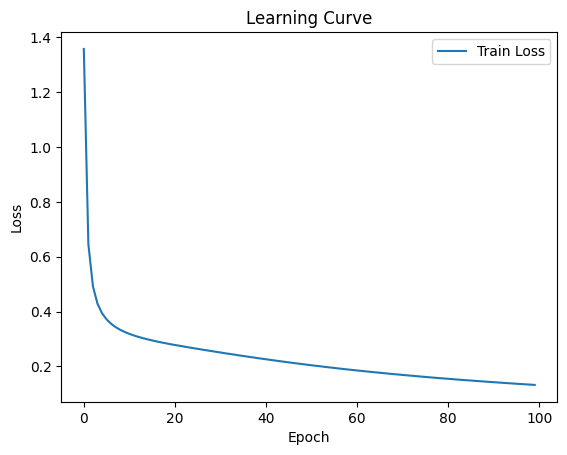

In [26]:
plt.plot(history.history['loss'])
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss'], loc='upper right')
plt.show()

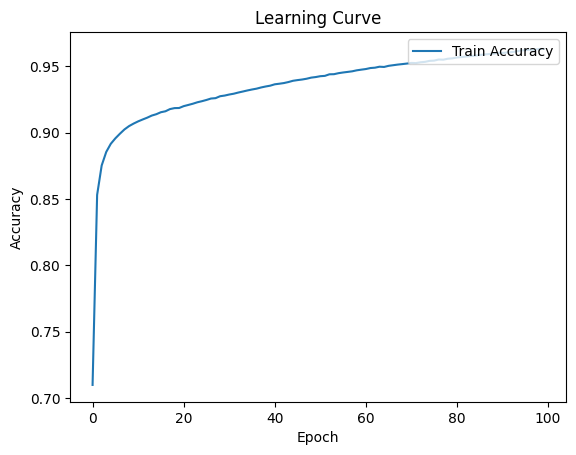

In [27]:

plt.plot(history.history['accuracy'])
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy'], loc='upper right')
plt.show()

# Naive Bayes


In [ ]:
%%capture
!unzip naive.zip

In [ ]:
classes = ['e', 's', 'j']
test_data = {'e' : {}, 's' : {}, 'j' : {}}
train_data = {'e' : {}, 's' : {}, 'j' : {}}
vocab = []
docount = 0
for filename in glob.glob("./naive/*"):
  classname = filename.split("/")[2][:-4]
  f = open(filename, 'r')
  sentences = f.read().splitlines()
  sentences = [x for x in sentences if x != '']
  words = []
  for item in sentences:
    words += item
  words = [x for x in words if x != '']
  if len(classname) == 3:
    currclass = classname[0]
    test_data[currclass][classname] = words
  else:
    docount += 1
    vocab += words
    currclass = classname[0]
    train_data[currclass][classname] = words
vocab = list(set(vocab))

In [ ]:
prior = {}
condprob = {}
total = 0
for t in vocab:
  condprob[t] = {}
for c, docs in train_data.items():
  classlen = len(docs)
  prior[c] = classlen/docount
  totalwords = []
  for doc, words in docs.items():
    totalwords += words
  total += len(totalwords)
  for t in vocab:
    counts = totalwords.count(t)
    condprob[t][c] = (counts + 0.5)/(len(totalwords) + 0.5*(len(vocab)))
print(total)

45617


In [ ]:
correct = 0
total = 0
predicted = []
true = []
correct = 0
for c, docs in test_data.items():
  for doc, words in docs.items():
    score = {}
    for c2 in classes:
      score[c2] = np.log(prior[c])
      for t in words:
        try:
          score[c2] += np.log(condprob[t][c2])
        except:
          pass
    # print(doc, score)
    prediction = max(score, key=score.get)
    total += 1
    correct += (prediction == c)
    predicted.append(prediction)
    true.append(c)
print("Accuracy is:", correct*100/total)
print(predicted)
print(true)

Accuracy is: 100.0
['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'j', 'j', 'j', 'j', 'j', 'j', 'j', 'j', 'j', 'j']
['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'j', 'j', 'j', 'j', 'j', 'j', 'j', 'j', 'j', 'j']


In [ ]:
for i in sorted(vocab):
  print(i, condprob[i]['s'])

print(test_data['e']['e10'])
result2 = {}
for item in test_data['e']['e10']:
  if item not in result2:
    result2[item] = 0
  result2[item] += 1

keys = sorted(result2)
for i in keys:
  print(i, result2[i])

  0.16826493170115014
a 0.10456045141993771
b 0.008232863618143134
c 0.03752582405722919
d 0.039745922111559924
e 0.1138108599796491
f 0.00860287996053159
g 0.0071844839813758445
h 0.0045327001942585795
i 0.049859702136844375
j 0.006629459467793161
k 0.0002775122567913416
l 0.052943171656748174
m 0.02580863988159477
n 0.054176559464709693
o 0.07249236841293824
p 0.02426690512164287
q 0.007677839104560451
r 0.05929511886774999
s 0.06577040485954797
t 0.03561407295488884
u 0.03370232185254849
v 0.00588942678301625
w 9.250408559711388e-05
x 0.0024976103111220747
y 0.007862847275754679
z 0.0026826184823163022
['e', 'x', 'c', 'e', 'p', 't', ' ', 'w', 'h', 'e', 'n', ' ', 't', 'h', 'e', ' ', 'w', 'i', 'n', 'd', 's', ' ', 'r', 'i', 's', 'e', ' ', 't', 'o', ' ', 'a', ' ', 'h', 'i', 'g', 'h', ' ', 's', 'p', 'e', 'e', 'd', ' ', 'w', 'e', ' ', 's', 'e', 'e', 'm', ' ', 't', 'o', ' ', 'l', 'i', 'v', 'e', ' ', 'i', 'n', ' ', 'a', ' ', 'v', 'e', 'r', 'y', ' ', 't', 'r', 'a', 'n', 'q', 'u', 'i', 'l', '

In [ ]:
x = test_data['e']['e10']
c = 'e'
sums = {}
for c2 in classes:
  sums[c2] = 0
  for t in x:
      sums[c2] += (np.log(condprob[t][c2])*result2[t])
print(sums)

sums = {}
for i in result2:
  for c in classes:
    if c not in sums:
      sums[c] = 0
    sums[c] += (np.log(condprob[i][c])*result2[i])
print(sums)

{'e': -1400741.4725990642, 's': -1485651.9399239856, 'j': -1585503.6136986252}
{'e': -7841.865447060635, 's': -8467.282044010557, 'j': -8771.433079075032}


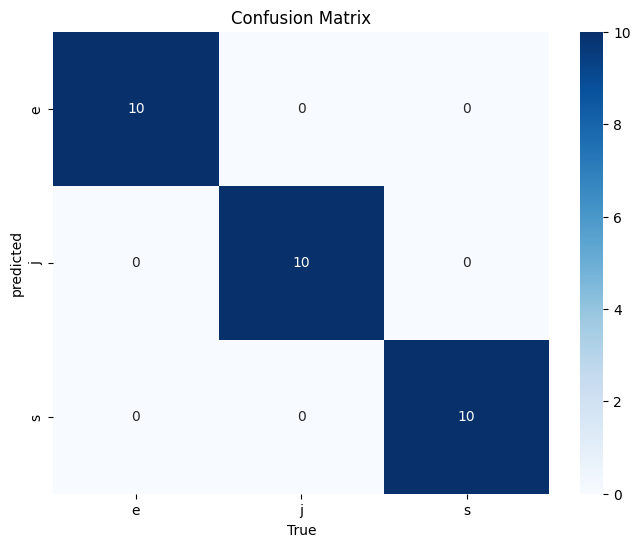

In [ ]:
class_labels = ['e', 'j', 's']

conf_matrix = confusion_matrix(predicted, true, labels=class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('True')
plt.ylabel('predicted')
plt.title('Confusion Matrix')
plt.show()